# Tarea 3 Ejercicio 1 - Introducción a las Redes Neuronales y Deep Learning

**Nombre:** Bruno Morici

**ROL USM:** 202373555-8

**Curso:** INF395, Introducción a las Redes Neuronales y Deep Learning

**Profesor:** Alejandro Veloz

**Fecha:** 9/11/2025

# CNN Reimplementada en Pytorch
* Para este ejemplo reimplementaré el entrenamiento que había hecho con FANN de el dataset MNIST pero con CNN.
* Se utilizará una arquitectura según se muestra en el siguiente esquema:

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchmetrics.classification import Accuracy, Precision, Recall

In [2]:
batch_size = 60

train_dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root="dataset/", download=True, train=False, transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.30MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 199kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.71MB/s]


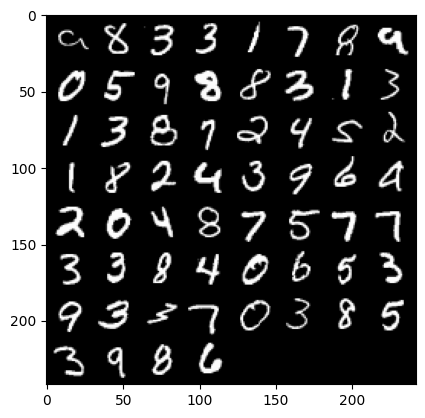

In [3]:
def imshow(img):
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1, 2, 0)))
   plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
labels
# show images
imshow(torchvision.utils.make_grid(images))

In [4]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes):

       """
       Building blocks of convolutional neural network.

       Parameters:
           * in_channels: Number of channels in the input image (for grayscale images, 1)
           * num_classes: Number of classes to predict. In our problem, 10 (i.e digits from  0 to 9).
       """
       super(CNN, self).__init__()

       # 1st convolutional layer
       self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
       # Max pooling layer
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       # 2nd convolutional layer
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       # Fully connected layer
       self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

   def forward(self, x):
       """
       Define the forward pass of the neural network.

       Parameters:
           x: Input tensor.

       Returns:
           torch.Tensor
               The output tensor after passing through the network.
       """
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       return x
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       return x

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNN(in_channels=1, num_classes=10).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)


In [7]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
num_epochs=10
for epoch in range(num_epochs):
 # Iterate over training batches
   print(f"Epoch [{epoch + 1}/{num_epochs}]")

   for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
       data = data.to(device)
       targets = targets.to(device)
       scores = model(data)
       loss = criterion(scores, targets)
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()

Epoch [1/10]


100%|██████████| 1000/1000 [00:25<00:00, 38.92it/s]


Epoch [2/10]


100%|██████████| 1000/1000 [00:24<00:00, 40.22it/s]


Epoch [3/10]


100%|██████████| 1000/1000 [00:26<00:00, 37.81it/s]


Epoch [4/10]


100%|██████████| 1000/1000 [00:30<00:00, 32.33it/s]


Epoch [5/10]


100%|██████████| 1000/1000 [00:27<00:00, 36.09it/s]


Epoch [6/10]


100%|██████████| 1000/1000 [00:25<00:00, 38.87it/s]


Epoch [7/10]


100%|██████████| 1000/1000 [00:28<00:00, 35.54it/s]


Epoch [8/10]


100%|██████████| 1000/1000 [00:27<00:00, 36.59it/s]


Epoch [9/10]


100%|██████████| 1000/1000 [00:27<00:00, 36.36it/s]


Epoch [10/10]


100%|██████████| 1000/1000 [00:26<00:00, 38.05it/s]


In [16]:
acc = Accuracy(task="multiclass", num_classes=10)
precision = Precision(task="multiclass", num_classes=10, average="macro")
recall = Recall(task="multiclass", num_classes=10, average="macro")

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        acc.update(preds, labels)
        precision.update(preds, labels)
        recall.update(preds, labels)
        
print(f"Accuracy:  {acc.compute():.4f}")
print(f"Precision: {precision.compute():.4f}")
print(f"Recall:    {recall.compute():.4f}")

Accuracy:  0.9913
Precision: 0.9913
Recall:    0.9912
